In [320]:
from music21 import *
from music21 import converter, instrument
import random
import networkx as nx
import numpy as np
import math
import scipy as sp
import keras as k


"""
Cerca Edit for Music Generation based off Midi Input
Difference from Attempt 1.3: Cleaner, more legible. More similarity metrics.
Author: Lauren Casey
"""

In [321]:
"""Cleans up matrix values"""
def matrixCleanup(matrix):
    matrix = matrix[matrix[:, 0].argsort()]#Sort rows
    matrix = matrix[:, matrix[0, :].argsort()]#Sort Columns
    length = len(matrix[0])-1
    for row in range(length):#For each row
        total = 0
        for j in range(length):#for each element in row find total
            total+=matrix[row+1][j+1]
        for i in range(length):#Find percentage for each element in row
            matrix[row+1][i+1] = matrix[row+1][i+1]/total
    return matrix

In [ ]:
"""Finds the shorter duration"""
def findSmaller(og, gen):
    if(len(og) <= len(gen)):
        return og  
    else:
        return gen
    
    
"""Finds the longer duration"""
def findBigger(og, gen):
    if(len(og) > len(gen)):
        return og
    else:
        return gen
    

: 

In [323]:
"""Turns a stream into array for easier use"""
def turnStreamIntoArray(s):
    array = []
    for e in s.iter().notes:
        array.append(e.duration.quarterLength)
    return array

"""Turns matrix into array for easier use"""    
def turnMatrixProbIntoArray(m):
    array = []
    i = 1
    
    print(m)
    print()
    while(i<len(m)):
        j = 1
        while(j<len(m)):
            array.append(m[i][j])
            j+=1
        i+=1
    
    print(array)
    return array

In [324]:
"""Calculates Cosine Similarity Duration"""
def cosineSimilarityDuration(original, generated):
    og = turnStreamIntoArray(original)
    gen = turnStreamIntoArray(generated)

    endHere = abs(len(og) - len(gen))
    if(len(og) > len(gen)):
        del og[:endHere]
    else:
        del gen[:endHere]

    dotProduct = np.dot(og, gen)
    magnitude = math.sqrt(dotProduct)
    
    return (dotProduct/magnitude)

In [325]:
"""Calculates Cosine Similarity Probability"""
def cosineSimilarityProbability(original, generated):
    og = turnMatrixProbIntoArray(matrixCleanup(durationMatrix(original)))
    gen = turnMatrixProbIntoArray(matrixCleanup(durationMatrix(generated)))
    
    dotProduct = np.dot(og ,gen)
    magnitude = math.sqrt(dotProduct)
    
    return (dotProduct/magnitude)

In [326]:
"""See if a matrix contains an element"""
def matrixContains(matrix, row, col):
    for e in matrix[:,0]:
        if(e == row):
            for i in matrix[0, :]:
                if(i == col):
                    return True
    return False

In [327]:
"""Generates Earth Movers Distance Matrix"""
def EMDMatrix(og, gen):
    scale = 1
    ogM = matrixCleanup(durationMatrix(og))
    genM = matrixCleanup(durationMatrix(gen))
    smallM = findSmaller(ogM, genM)
    bigM = findBigger(ogM, genM)
    length = len(smallM)

    if(smallM == og):
        scale = len(gen)/len(og)
    else:
        scale = len(og)/len(gen)


        
    
    total = 0;
    dist = 0;
    e = 0;
    while(e<length):
        i = 0;
        startingRow = smallM[e][0] #grab smaller matrix's duration
        
        while(i<length):
            if(matrixContains(bigM, startingRow, bigM[0][i])):
                dist += abs((smallM[e][i]) - bigM[e][i])
            total += ((smallM[e][i]) + bigM[e][i])
            i+=1
        e+=1
    print("*******************************************************************************************************************")
    print("EMD - returns a number symbolizing minimal work to change one song into the other. \nSo in this case, how many changes to go from one song to the other. Therefore, the higher number, the more changes, the less similar.\nNote: **This is comparing each note at a time**")
    print("\nEarth Movers Distance: ", dist)
    print("EMD - Percent of Changes Needed: ", (dist/total)*100)   
        

In [328]:
"""Calculates the Earth Movers Distance between streams"""
def EMD(original, generated):
    #Earth Movers Distance: two same size piles of dirt. Finds minimal cost of turning one pile into the other. 
    #Cost = amount of dirt being moved * distance moved
    
    smallerStream = findSmaller(original, generated)
    biggerStream  = findBigger(original, generated)
    
    i = 0
    earthMoversDistance = 0
    totalDistance = 0
    
    while(i<len(smallerStream)):
        #dirt = original[i].duration.quarterLength
        dirt = 1
        distance = abs(smallerStream[i].duration.quarterLength - biggerStream[i].duration.quarterLength)
        totalDistance += smallerStream[i].duration.quarterLength + biggerStream[i].duration.quarterLength
        earthMoversDistance += (dirt*distance)
        i+=1
        
        
    print("*******************************************************************************************************************")
    print("EMD - returns a number symbolizing minimal work to change one song into the other. \nSo in this case, how many changes to go from one song to the other. Therefore, the higher number, the more changes, the less similar.\nNote: **This is comparing each note at a time**")
    print("\nEarth Movers Distance: ", earthMoversDistance)
    print("EMD - Percent of Changes Needed: ", (earthMoversDistance/totalDistance)*100)
    return earthMoversDistance
        
    

In [329]:
"""Calculates the Euclidean Distance between streams"""
def euclideanDistance(original, generated):
    og = matrixCleanup(durationMatrix(original))
    gen = matrixCleanup(durationMatrix(generated))
    
    total = 0;
    sumSquared = 0;
    small = findSmaller(og, gen)
    big = findBigger(og, gen)

    length = len(small)
    e = 1
    i = 1
    while(e < length):
        while(i < length):
            if(matrixContains(big, small[e][0], small[0][i])):
                sumSquared += pow((small[e][i]) - big[e][i], 2)
                total += (small[e][i])+big[e][i]
            i+=1
        e+=1
    euDist = math.sqrt(sumSquared)
    total = math.sqrt(total)
    print("*******************************************************************************************************************")
    print("Euclidean Distance - the higher number it returns, the less similar.")
    print("\nGenerated Matrix Euclidean Distance: ", euDist)

In [384]:
"""Calculates the Average Distance between Streams"""
def averageDifference(original, generated):
    og = matrixCleanup(durationMatrix(original))
    gen = matrixCleanup(durationMatrix(generated))
    sumD = 0
    sm = findSmaller(og, gen)
    b = findBigger(og, gen)
    
    if(sm.all == og.all):
        scale = len(generated)/len(original)
    else:
        scale = len(original)/len(generated)
        
        
    e = 1
    i = 1
    count = 0
    
    while(e<len(sm)):
        while(i<len(sm)):
            if(matrixContains(b, sm[e][0], sm[0][i])):
                sumD += abs((sm[e][i]) - b[e][i])
                count +=1
            i+=1
        e+=1
    print("Average Diff: ", sumD/count)

In [385]:
"""
Parameters: 
prev - previous note/duration chosen
matrix - note/duration matrix

Returns:
note/duration chosen to append to stream

Function: 
Chooses the next note/duration randomly
"""
def choose(prev, matrix):
    choosing = True
    if prev == None:
        while(choosing):
            rowIndex = random.randrange(1, len(matrix)-1)
            colIndex = random.randrange(1, len(matrix)-1)
            if(matrix[rowIndex][colIndex] != 0.0):
                choosing = False;
                return matrix[0][colIndex]
    else:
        while(choosing):
            rowIndex = np.where(matrix[:, 0] == prev)[0]
            colIndex = random.randrange(1, len(matrix)-1)
            temp = ((matrix[rowIndex,:])[0])[colIndex]
            if(temp != 0.0):
                choosing = False;
                return matrix[0][colIndex]

In [386]:
"""Generates stream of durations"""

def generateDur(horn, DMatrix,D, beatsToGen):
    i = 0
    chosen = choose(None, DMatrix)
    D.append(note.Note( quarterLength = chosen))
    while i < beatsToGen:
        chosen = choose(chosen, DMatrix)
        
        if (chosen <= beatsToGen - i):
            D.append(note.Note(quarterLength = chosen))
            i+=chosen
            
            
    total = len(findSmaller(horn, D))
    
    matrixOG = matrixCleanup(durationMatrix(horn))
    matrixGen = matrixCleanup(durationMatrix(D))

    print("Length of Original: ", len(horn))
    print("Length of Generated: ", len(D))
    print("*******************************************************************************************************************")
    print("Similarity Metrics")
    euclideanDistance(horn, D)
    EMDMatrix(horn, D)
    averageDifference(horn, D)
    print("*******************************************************************************************************************")
    print("Cosine Similarity - returns an angle. The smaller the angle, the more similar...")
    CS = cosineSimilarityDuration(horn, D)
    print("\nCosine Similarity (Duration): ", CS)
    
    D.show()

In [387]:
"""Generates stream of durations by number of beats"""
def generateDurByBeats(horn, DMatrix,D, numer, measures):
    m = 0
    chosen = choose(None, DMatrix)
    D.append(note.Note(quarterLength = chosen))
    while(m < measures):
        b = 0
        while b < numer:
            chosen = choose(chosen, DMatrix)
                
            b+=chosen
            D.append(note.Note(quarterLength = chosen))
        m+=1
        
        
    total = len(findSmaller(horn, D))
    
    matrixOG = matrixCleanup(durationMatrix(horn))
    matrixGen = matrixCleanup(durationMatrix(D))

    print("Length of Original: ", len(horn))
    print("Length of Generated: ", len(D))
    print("*******************************************************************************************************************")
    print("Similarity Metrics")
    euclideanDistance(horn, D)
    EMDMatrix(horn, D)
    averageDifference(horn, D)
    print("*******************************************************************************************************************")
    print("Cosine Similarity - returns an angle. The smaller the angle, the more similar...")
    CS = cosineSimilarityDuration(horn, D)
    print("\nCosine Similarity (Duration): ", CS)
    
    D.show()

In [400]:
"""Generates stream of Notes"""
def generateNote(horn, NMatrix,N, beatsToGen):
    i = 0
    while i < beatsToGen:
        chosen = choose(None, NMatrix)
        if(chosen == -1.0):
            N.append(note.Rest(quarterLength = 1))
        else:
            tempNote = note.Note(quarterLength = 1)
            tempNote.pitch.frequency = chosen
            N.append(tempNote)
        i+=1
    
    total = len(findSmaller(horn, N))
    
    matrixOG = matrixCleanup(noteMatrix(horn))
    matrixGen = matrixCleanup(noteMatrix(N))

    print("Length of Original: ", len(horn))
    print("Length of Generated: ", len(N))
    print("*******************************************************************************************************************")
    print("Similarity Metrics")
    euclideanDistance(horn, N)
    EMDMatrix(horn, N)
    averageDifference(horn, N)
    print("*******************************************************************************************************************")
    print("Cosine Similarity - returns an angle. The smaller the angle, the more similar...")
    CS = cosineSimilarityDuration(horn, N)
    print("\nCosine Similarity (Duration): ", CS)
            
    N.show()

In [401]:
"""
Chooses which note and which duration are next in the song
"""
def chooseND(r, c, matrix):
    choosing = True
    if c == None:
        while(choosing):
            rowIndex = random.randrange(1, len(matrix)-1)
            colIndex = random.randrange(1, len(matrix)-1)
            if(matrix[rowIndex][colIndex] != 0.0):
                choosing = False;
                return rowIndex, colIndex
    else:
        while(choosing):
            rowIndex = np.where(matrix[:, 0] == c)[0]
            colIndex = random.randrange(1, len(matrix)-1)
            temp = ((matrix[rowIndex,:])[0])[colIndex]
            if(temp != 0.0):
                choosing = False;
                return rowIndex, colIndex

In [402]:
"""Finds Key Value Pair In Dictionary"""
def getValueInDict(m, d, r):
    for key in d:
        if(key == m[r, 0]):
            return d[key]

In [410]:
"""
Parameters: 
horn - horn part in inputted music
m, d - used to find key value pair in dictionary
ND - number of beats to generate in the song
beatsToGen - number of beats to generate in the song

Returns:
Stream of generated music of durations/notes

Function: 
Generates a specified length of music of durations/notes based on input
"""

def generateNoteDur(horn, m,d, ND, beatsToGen):
    i = 0;
    chosenR = None
    chosenC = None
    while i < beatsToGen:
        chosenR, chosenC = chooseND(chosenR, chosenC, m)
        
        durNoteAr = getValueInDict(m, d, chosenR)
        if(durNoteAr[1] == -1):
            ND.append(note.Rest(quarterLength = durNoteAr[0]))
        else:
            newNote = note.Note(quarterLength = durNoteAr[0])
            newNote.pitch.frequency = durNoteAr[1]
            ND.append(newNote)
        i+=1
    total = len(findSmaller(horn, ND))
    print("Length of Original: ", len(horn))
    print("Length of Generated: ", len(ND))
    print("*******************************************************************************************************************")
    print("Similarity Metrics")
    euclideanDistance(horn, ND)
    EMDMatrix(horn, ND)
    averageDifference(horn, ND)
    print("*******************************************************************************************************************")
    print("Cosine Similarity - returns an angle. The smaller the angle, the more similar...")
    CS = cosineSimilarityDuration(horn, ND)
    print("\nCosine Similarity (Duration): ", CS)
    
    ND.show()

In [411]:

"""
Parameters: 
horn - horn part in inputted music

Returns:
Duration Matrix

Function: 
Matrix of probabilities of transitioning between durations in input music
"""

def durationMatrix(horn):
    #Creates matrix of duration changes
    matrix = np.array([[0]])
    prev = None
    for e in horn.iter().notesAndRests:#loop through each note and rest
        cur = e.duration.quarterLength
        if cur not in matrix[0]:#Adds column and row to matrix
            n,m = matrix.shape
            add = np.zeros((n, 1))
            add[0] = cur
            matrix = np.hstack((matrix, add))
            add = np.append(add, 0)
            matrix = np.vstack((matrix, add))
        if prev != None:#Increments matrix value
            prevInd = np.where(matrix[0] == prev)[0][0]
            curInd = np.where(matrix[0] == cur)[0][0]
            matrix[prevInd][curInd] = (matrix[prevInd][curInd]+1)
        prev = cur
    return matrix

In [412]:

"""
Parameters: 
horn - horn part in inputted music

Returns:
Note and Duration Matrix

Function: 
Matrix of probabilities of transitioning between durations/notes in input music
"""

def noteDurationMatrix(horn):
    d = {}#Creates a dictionary containing an index and a list of the values
    matrix = np.array([[0]])
    prev = None
    for e in horn.iter().notesAndRests:
        count = 0
        contains = False
        if e.name == 'rest':#Rest is -1
            curFre = -1
        else:
            curFre = e.pitch.frequency
        curDur = e.duration.quarterLength
        value = [curDur, curFre]#List of values
        for i in range(len(d)):#Check if value is in the dictionary
            if np.equal(d[i], value).all():
                contains = True
                break
            count += 1#keep track of what index
        if not contains:#Value is not in matrix, must add it
            d.update({count : value})
            n,m= matrix.shape
            add = np.zeros((n, 1))
            add[0] = count
            matrix = np.hstack((matrix, add))
            add = np.append(add, 0)
            matrix = np.vstack((matrix, add))
        if prev != None:#Increments matrix value
            matrix[prev+1][count+1] = (matrix[prev+1][count+1]+1)#Must be count +1 or it will add to the label column
        prev = count
    return matrix, d#return matrix and dictionary

In [413]:
"""
Parameters: 
horn - horn part in inputted music

Returns:
Note Matrix

Function: 
Matrix of probabilities of transitioning between notes in input music
"""

def noteMatrix(horn):
    #Creates matrix of duration changes
    matrix = np.array([[0]])
    prev = None
    for e in horn.iter().notesAndRests:#loop through each note
        if e.name == 'rest':
            cur = -1
        else:
            cur = e.pitch.frequency
        if cur not in matrix[0]:#Adds column and row to matrix
            n,m = matrix.shape
            add = np.zeros((n, 1))
            add[0] = cur
            matrix = np.hstack((matrix, add))
            add = np.append(add, 0)
            matrix = np.vstack((matrix, add))
        if prev != None:#Increments matrix value
            prevInd = np.where(matrix[0] == prev)[0][0]
            curInd = np.where(matrix[0] == cur)[0][0]
            matrix[prevInd][curInd] = (matrix[prevInd][curInd]+1)
        prev = cur
        
    return matrix

In [414]:
"""
Parameters: 
clef - Clef of Generated Music
key - Key of Generated Music
time - Time of Generated Music
title - Title of Generated Music

Returns:
Stream

Function: 
Creates a stream to append note/durations to, to create generated music
"""

def makeStream(clef, key, time, title):
    name = stream.Stream()
    name.append(clef)
    name.append(key)
    name.append(time)
    name.insert(0, metadata.Metadata())
    name.metadata.title = title
    
    return name
  

In [415]:
"""
Function:
Gets the song inputted and breaks it apart for song generation
"""

def songGrab():

#get Bach song
    chorals = corpus.search('mozart/k155/movement2.mxl')
    testSong = chorals[0].parse()
    
    
#grab time sig, key sig, and clef
    originalTimeSig = testSong.recurse().getElementsByClass(meter.TimeSignature)[0]
    originalKeySig = testSong.recurse().getElementsByClass(key.KeySignature)[0]
    originalClef = testSong.recurse().getElementsByClass(clef.Clef)[0]
    
#make some extra streams for etude output with the originals time sig, key sig, and clef
    D = makeStream(originalClef, originalKeySig, originalTimeSig, "Quartet No. 2 : Generated Rhythm Etude")
    N = makeStream(originalClef, originalKeySig, originalTimeSig, "Quartet No. 2 : Generated Pitch Etude")
    ND = makeStream(originalClef, originalKeySig, originalTimeSig, "Quartet No. 2 : Generated Pitch & Rhythm Etude")
    
    measures = len(testSong.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure))


#use horn part of chosen Bach song
    horn = testSong.parts[2].recurse()
    horn.show()
    
    matrixOG = matrixCleanup(durationMatrix(horn))
    matrixGen = matrixCleanup(durationMatrix(D))
    
    
#grab time sig - this is for counting up to the correct number of beats in measure when producing etude
    numer = horn.recurse().getElementsByClass(meter.TimeSignature)[0].numerator
#generate new etude

    beatsToGen = measures*numer
    temp = len(horn)
    #generateDurByBeats(horn, durationMatrix(horn),D, numer, measures)
    #print("*******************************************************************************************************************")
    #print("*******************************************************************************************************************")
    #print("*******************************************************************************************************************")
    generateDur(horn, durationMatrix(horn), D, temp)
    generateNote(horn, noteMatrix(horn), N, temp)
    m, d = noteDurationMatrix(horn)
    generateNoteDur(horn,m, d, ND, temp)
    

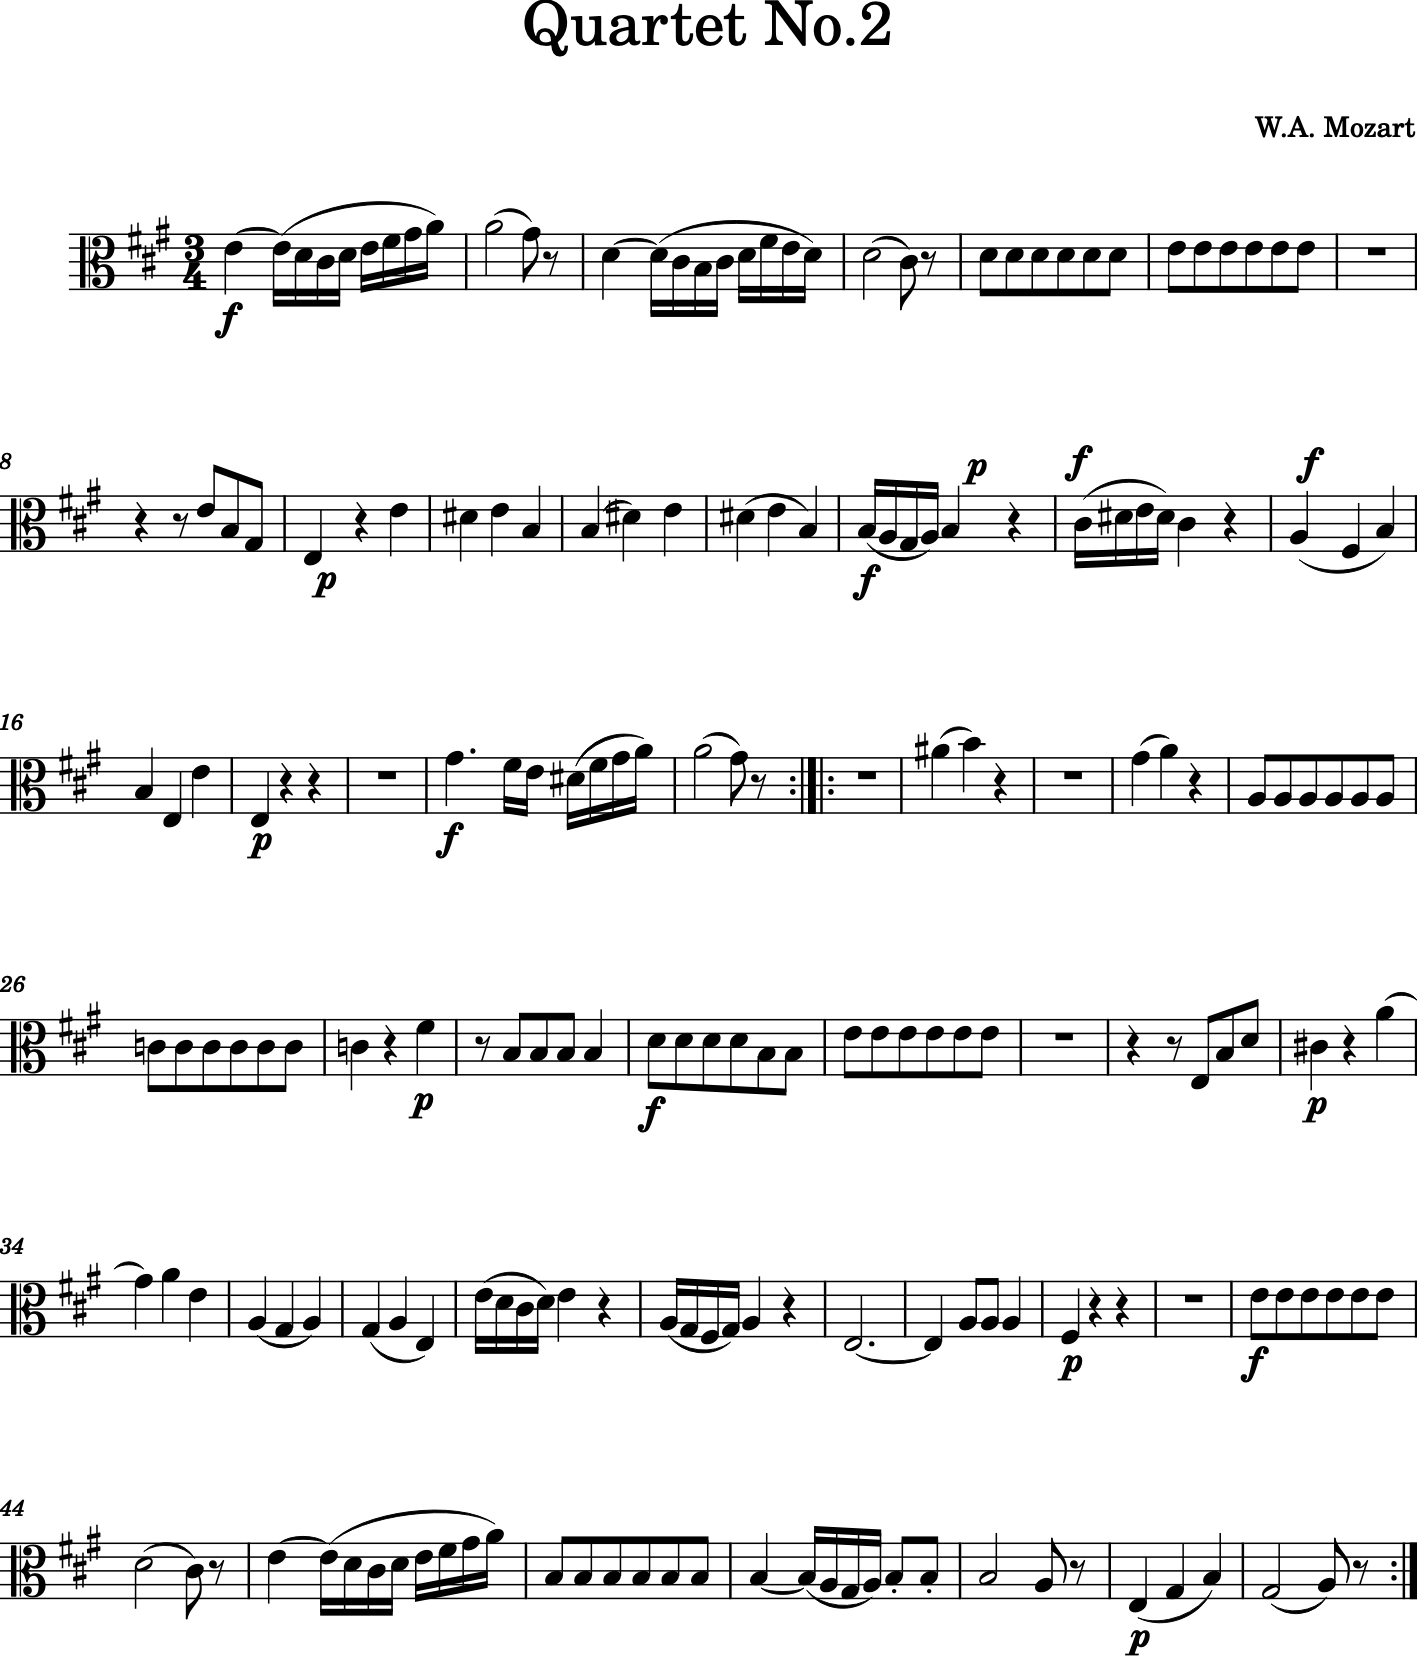

Length of Original:  299
Length of Generated:  271
*******************************************************************************************************************
Similarity Metrics
*******************************************************************************************************************
Euclidean Distance - the higher number it returns, the less similar.

Generated Matrix Euclidean Distance:  0.5716363932518339
*******************************************************************************************************************
EMD - returns a number symbolizing minimal work to change one song into the other. 
So in this case, how many changes to go from one song to the other. Therefore, the higher number, the more changes, the less similar.
Note: **This is comparing each note at a time**

Earth Movers Distance:  8.823558469889477
EMD - Percent of Changes Needed:  26.02937735058619
Average Diff:  0.21082352941176472
***********************************************************

<ipython-input-327-331b6dfafa87>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if(smallM == og):
<ipython-input-327-331b6dfafa87>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(smallM == og):



Cosine Similarity (Duration):  11.219402836158439


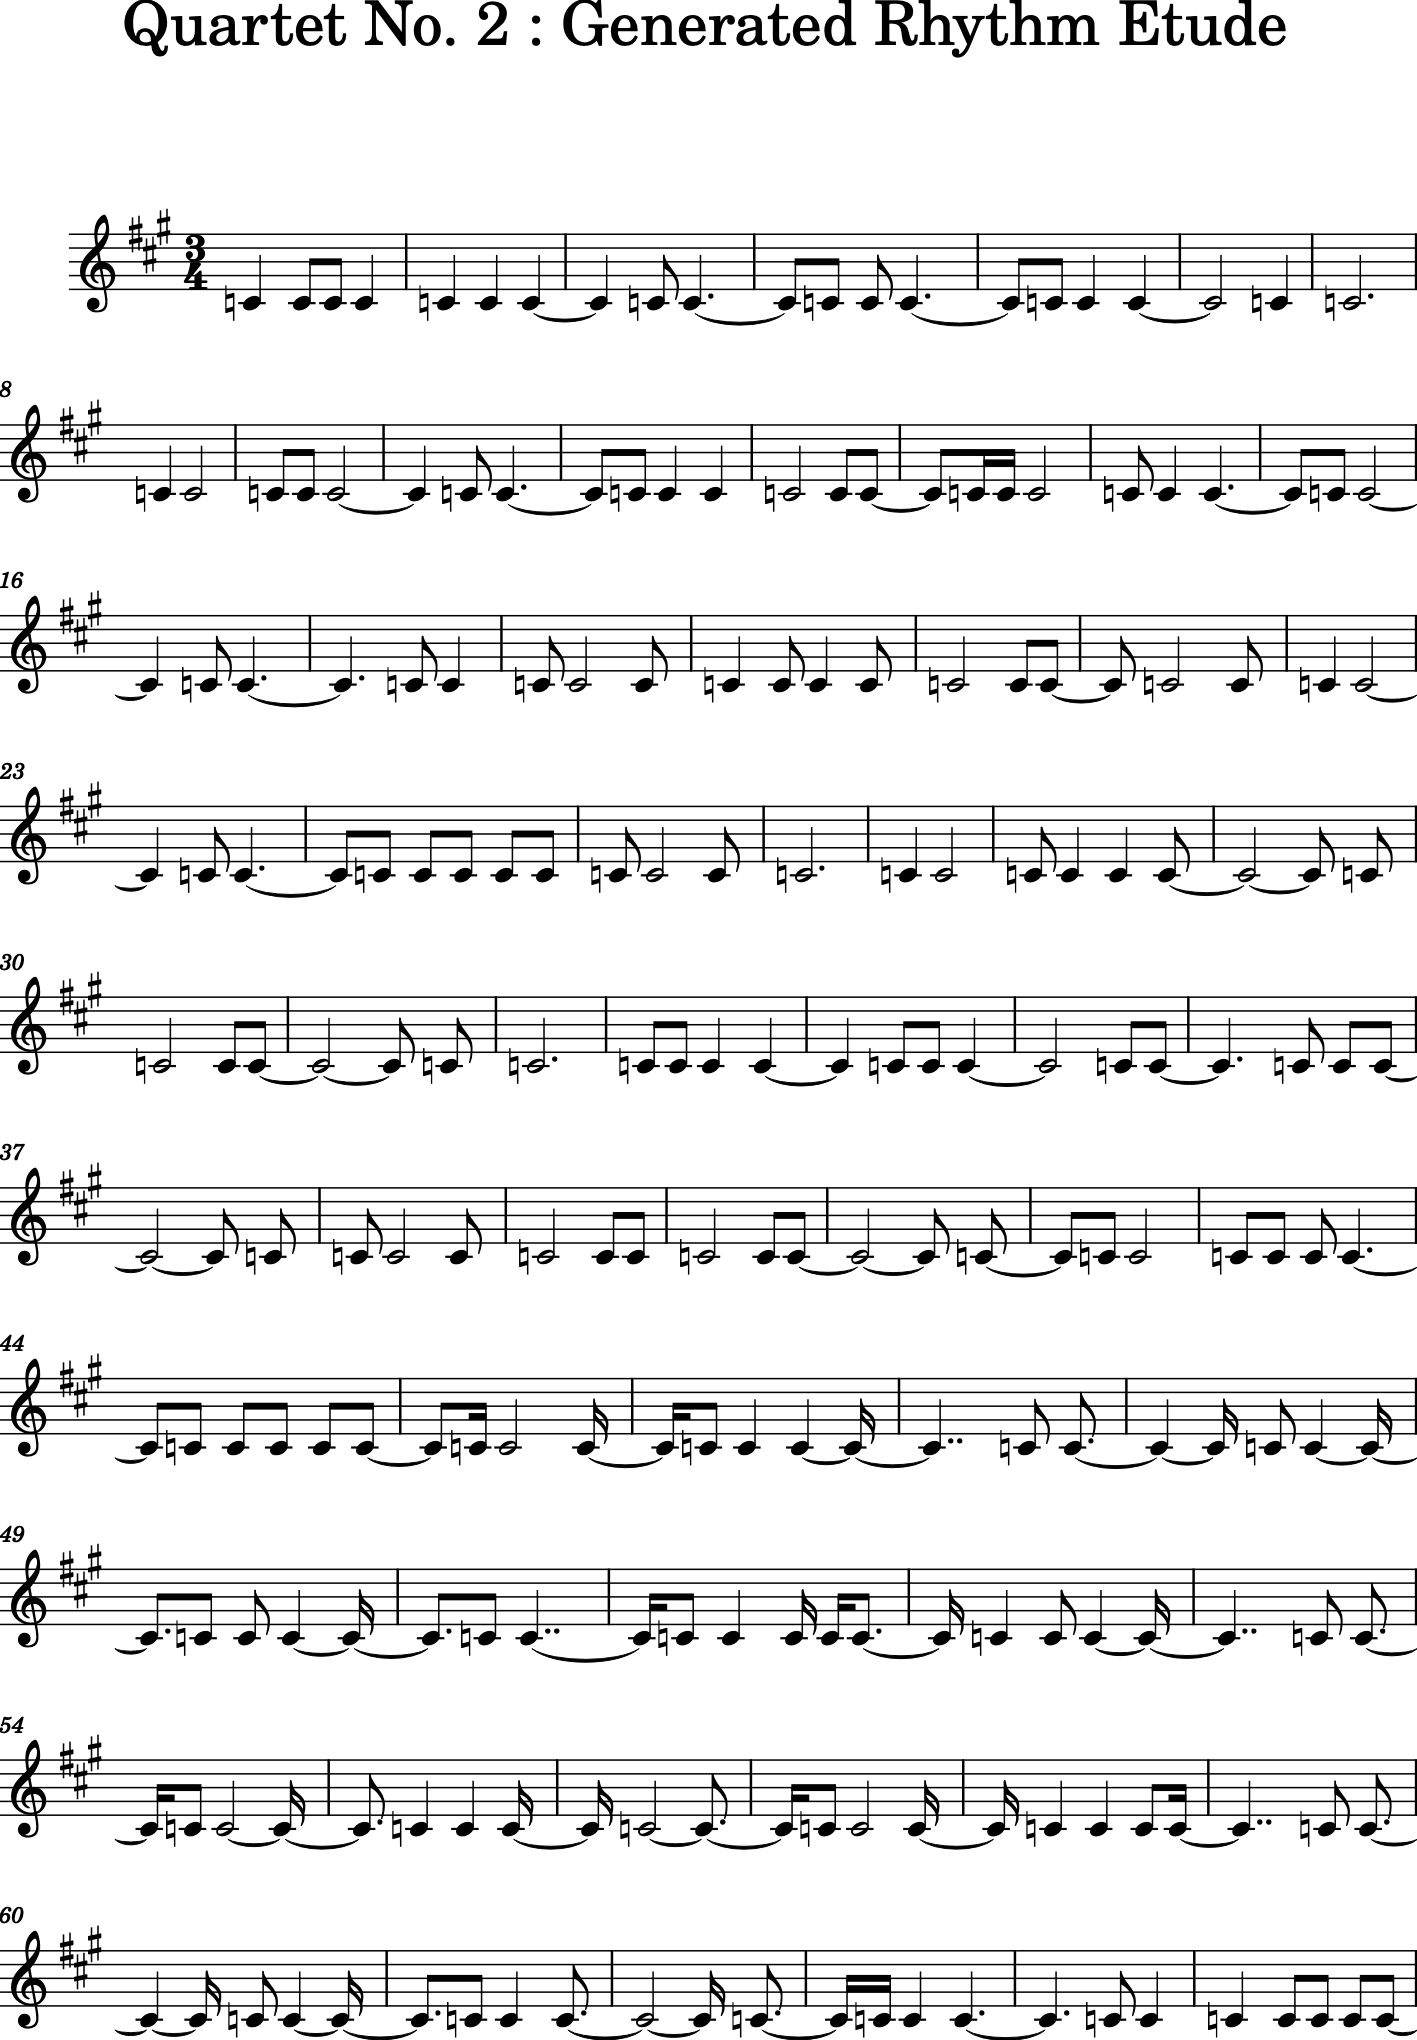

Length of Original:  299
Length of Generated:  303
*******************************************************************************************************************
Similarity Metrics
*******************************************************************************************************************
Euclidean Distance - the higher number it returns, the less similar.

Generated Matrix Euclidean Distance:  0.18000000000000005
*******************************************************************************************************************
EMD - returns a number symbolizing minimal work to change one song into the other. 
So in this case, how many changes to go from one song to the other. Therefore, the higher number, the more changes, the less similar.
Note: **This is comparing each note at a time**

Earth Movers Distance:  1.6800000000000002
EMD - Percent of Changes Needed:  38.88888888888889
Average Diff:  0.18000000000000005
*********************************************************

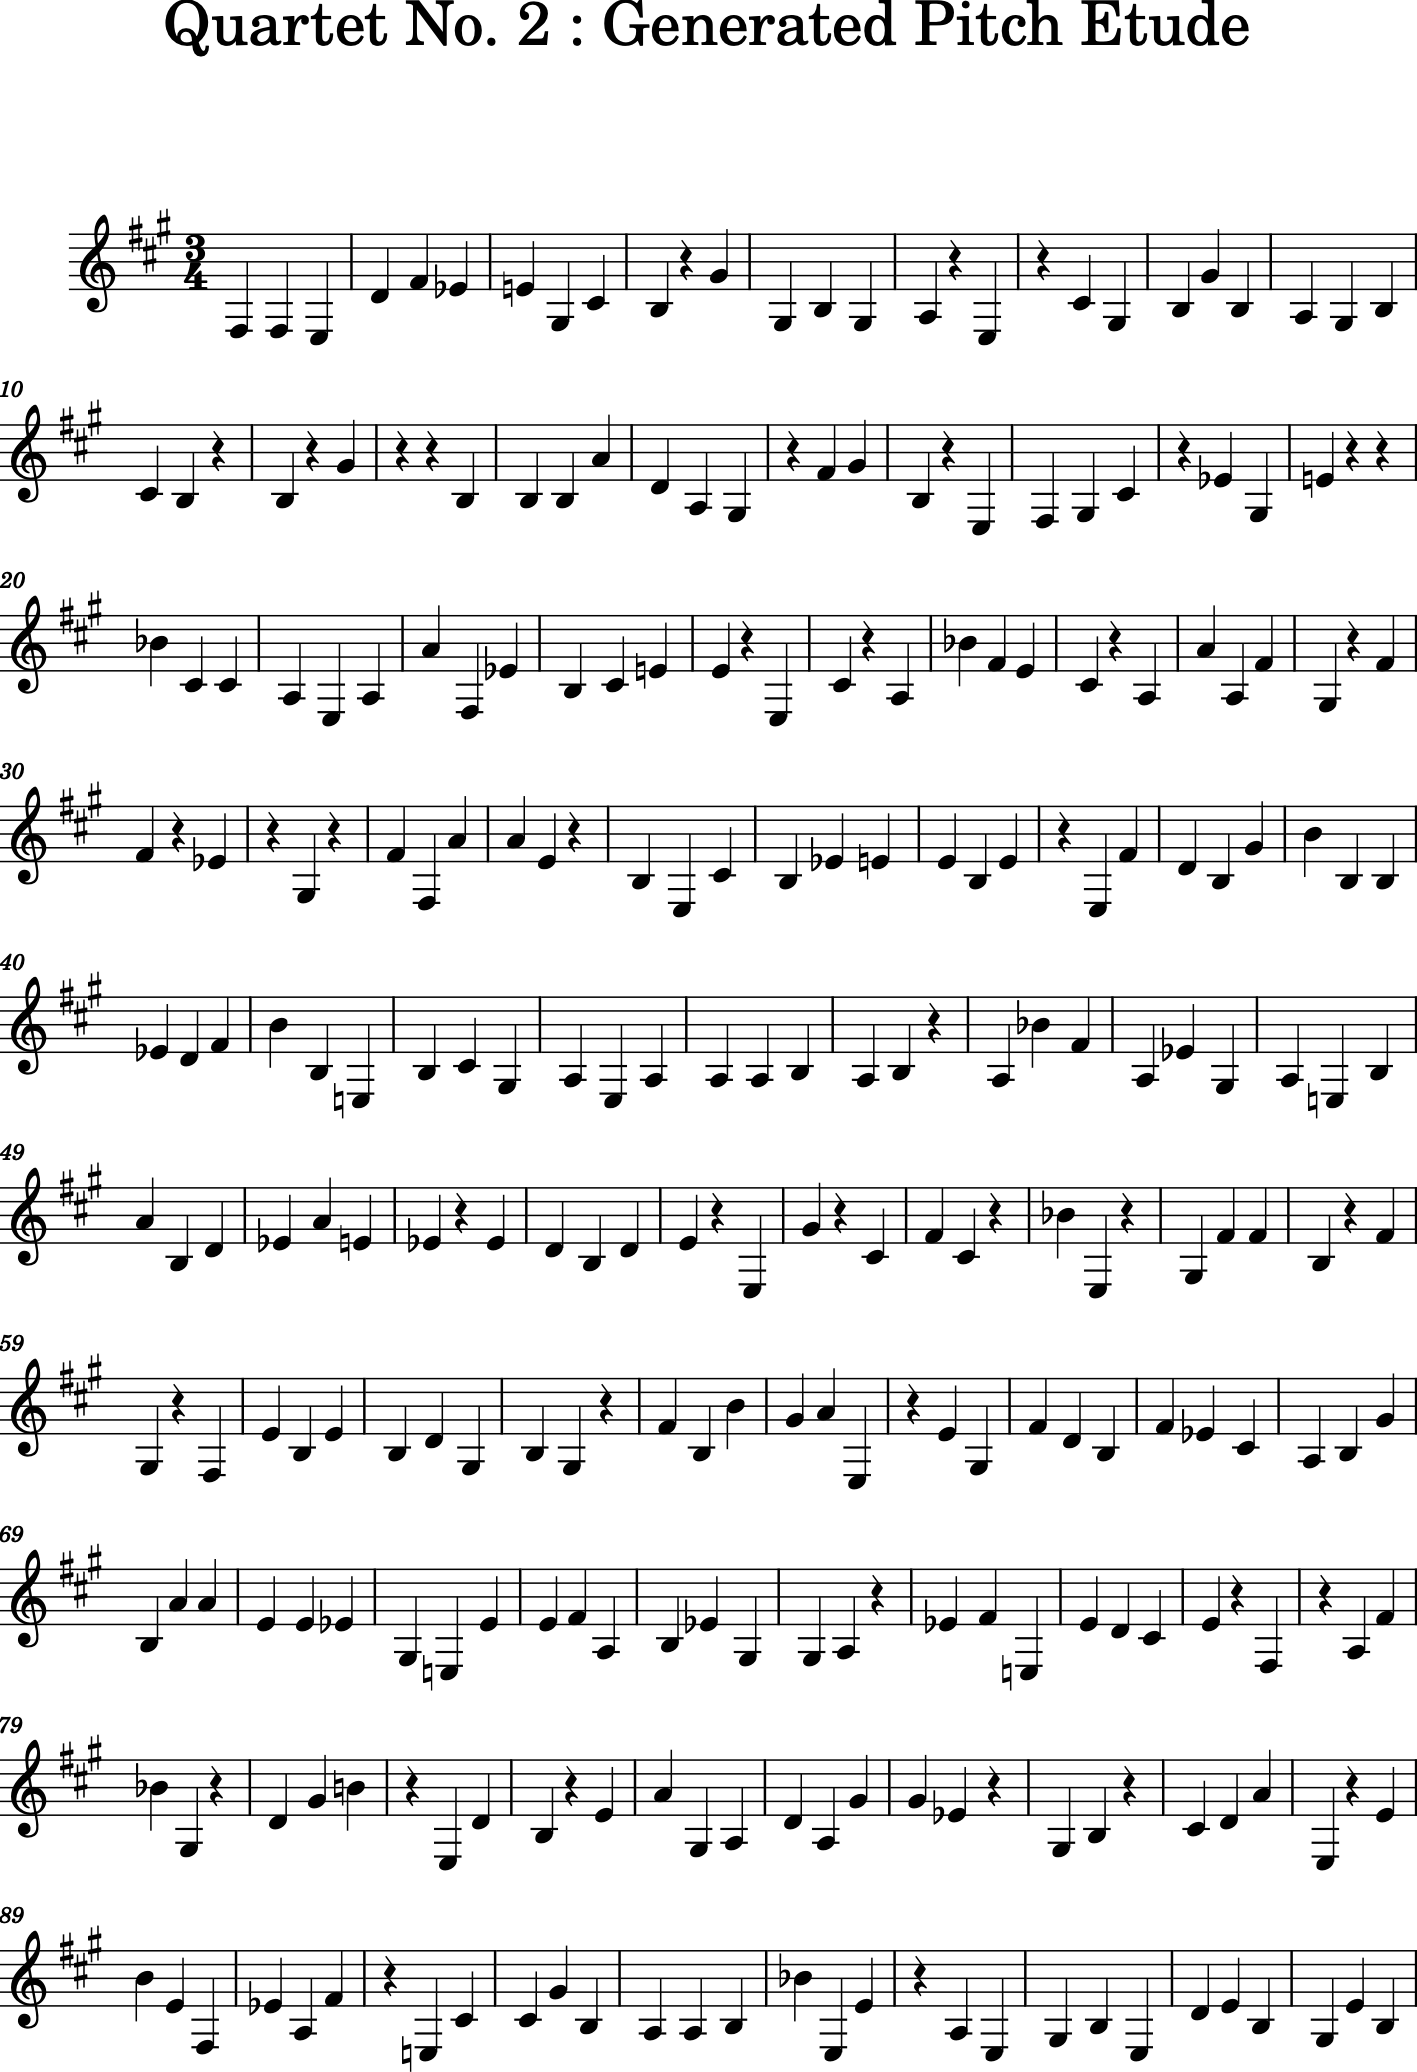

Length of Original:  299
Length of Generated:  303
*******************************************************************************************************************
Similarity Metrics
*******************************************************************************************************************
Euclidean Distance - the higher number it returns, the less similar.

Generated Matrix Euclidean Distance:  0.3778258367938332
*******************************************************************************************************************
EMD - returns a number symbolizing minimal work to change one song into the other. 
So in this case, how many changes to go from one song to the other. Therefore, the higher number, the more changes, the less similar.
Note: **This is comparing each note at a time**

Earth Movers Distance:  3.531236908173633
EMD - Percent of Changes Needed:  7.847193129274739
Average Diff:  0.10666666666666667
***********************************************************

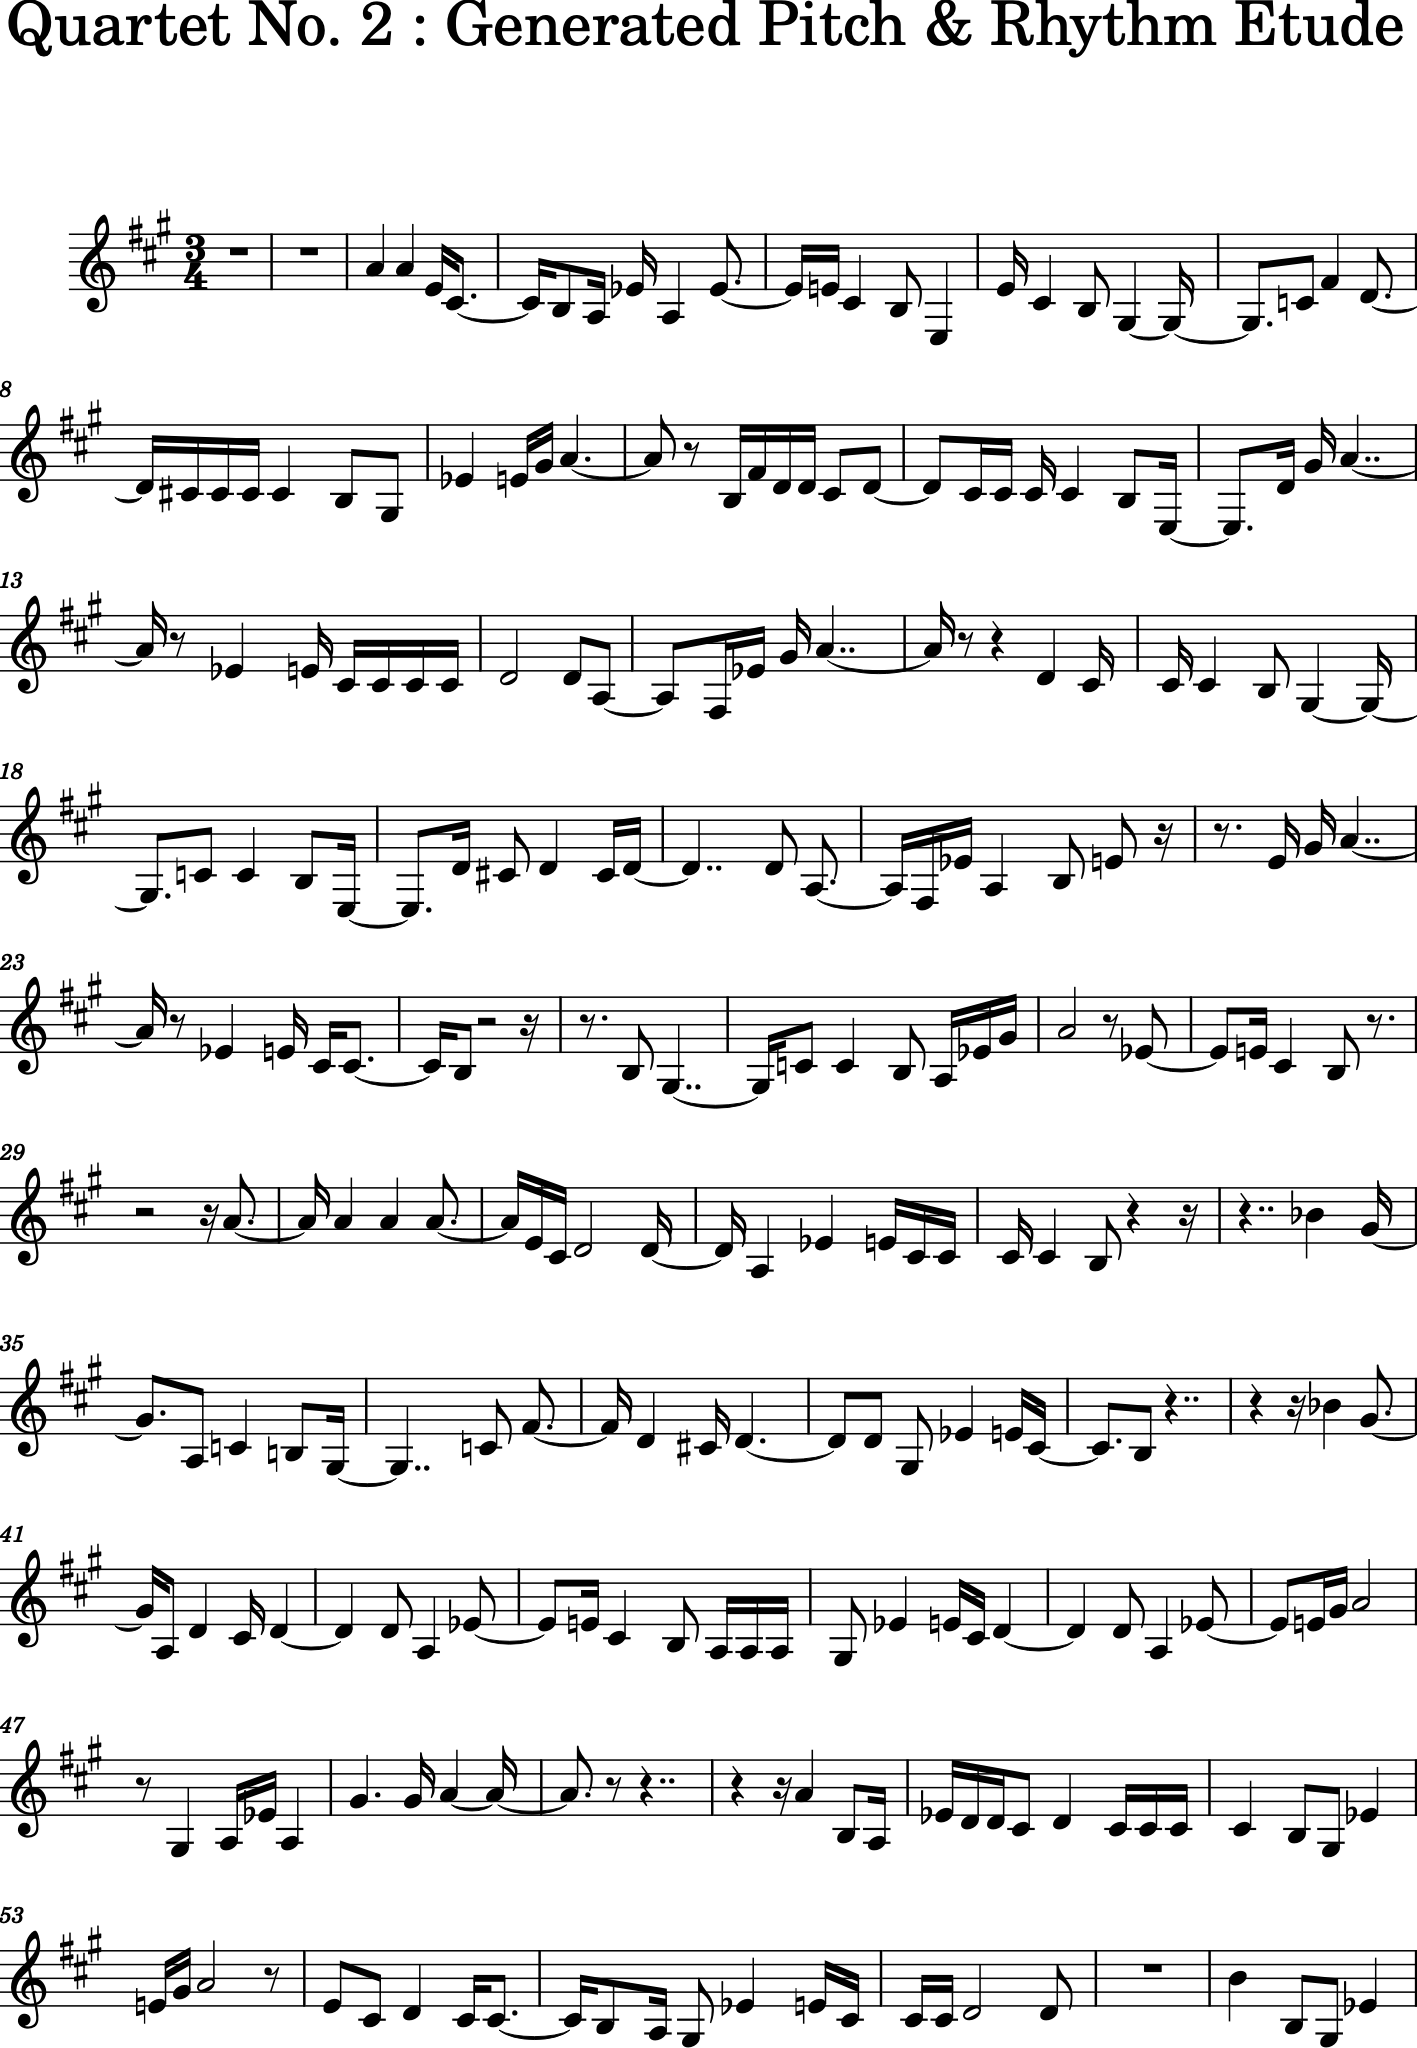

In [416]:
"""Initiate Process"""
songGrab()

